In [168]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import Optimizer
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, BatchSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms as tf
from torchvision.models import vgg16, VGG, VGG16_Weights

from torchinfo import summary

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [169]:
def set_seeds(seed: int = 42):
    """
    Sets random seed for reproducibility.
    :param seed: (int, optional): Random seed. Defaults to 42
    :return: 
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [170]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [171]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")    

Using device: cpu


# Create Celebs Dataset

In [172]:
available_modes = ['train', 'val', 'test']
images_path = './celebA_train_500/celebA_imgs/'
class CelebDataset(Dataset):
    def __init__(self, mode: str = 'train'):
        if mode not in available_modes:
            raise ValueError(f'Unrecognized mode: {mode}')
        df = pd.read_csv('./celebA_train_500/celebA_train_split.txt', sep=' ', names=['Image', 'Mode'])
        self.image_annos = pd.read_csv('./celebA_train_500/celebA_anno.txt', sep=' ', names=['Image', 'Person'])
        self.train_images = df[df['Mode'] == 0]['Image'].to_numpy(dtype=str)
        self.val_images = df[df['Mode'] == 1]['Image'].to_numpy(dtype=str)
        self.test_images = df[df['Mode'] == 2]['Image'].to_numpy(dtype=str)
        self._mode = mode
    
    def __len__(self):
        return len(self.get_images_depend_on_mode())
    
    def __getitem__(self, index):
        image_name = self.get_images_depend_on_mode()[index]
        image_path = images_path + image_name
        image = np.array(Image.open(image_path))
        image = Image.fromarray(image[77:-41, 45:-50])
        transform = tf.Compose([tf.ToTensor()])
        transformed_image = transform(image)
        annotation: pd.DataFrame = self.image_annos
        person_id = annotation[annotation['Image'] == image_name]['Person'].values[0]
        return transformed_image, person_id
        
    def get_images_depend_on_mode(self) -> np.array:
        if self._mode == 'train':
            return self.train_images
        elif self._mode == 'val':
            return self.val_images
        elif self._mode == 'test':
            return self.test_images
        else:
            raise ValueError(f'Unrecognized mode: {self._mode}')
        
        

In [173]:
train_dataset = CelebDataset(mode='train')
val_dataset = CelebDataset(mode='val')
test_dataset = CelebDataset(mode='test')

# Let's look at cropped images from celeb dataset

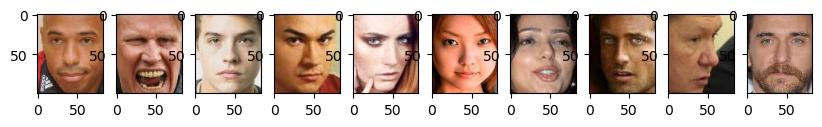

In [174]:
import random

nrows, ncols = 1,  10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
ax = ax.flatten()
to_pil = tf.ToPILImage()
for i in range(nrows * ncols):
    rand_index = random.randint(0, len(train_dataset) - 1)
    image_tensor = train_dataset.__getitem__(rand_index)[0]
    pil_image = to_pil(image_tensor)
    ax[i].imshow(pil_image)



# # Plot more images
# torch.manual_seed(42)
# fig = plt.figure(figsize=(9, 9))
# rows, cols = 4, 4
# for i in range(1, rows * cols + 1):
#     random_idx = torch.randint(0, len(train_data), size=[1]).item()
#     img, label = train_data[random_idx]
#     fig.add_subplot(rows, cols, i)
#     plt.imshow(img.squeeze(), cmap="gray")
#     plt.title(class_names[label])
#     plt.axis(False);


In [196]:
batch_size = 100

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

## Train Loop

Let's describe a train function which we well user for all experiments with face recognition.

In [176]:
# def eval_accuracy(model: Module, dataloader: DataLoader):
#     model.eval()
#     timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
#     summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
#     for _, (images, labels) in enumerate(dataloader):
#         with torch.no_grad():
#             outputs = model(images)
#             
        

In [198]:
def train_step(model: Module, train_dataloader: DataLoader, criterion, optimizer: Optimizer) -> (float, float):
    model.train(True)
    train_loss, train_acc = 0.0, 0.0
    for _, (images, labels) in enumerate(train_dataloader):
        images = images.to(device=device)
        labels = labels.to(device=device)
        output = model(images)
        loss: Tensor = criterion(output, labels)
        train_loss += loss.item()
        # calculate accuracy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_dataloader), train_acc


def val_step(model: Module, val_dataloader: DataLoader, criterion) -> (float, float):
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.inference_mode():
        for _, (images, labels) in enumerate(val_dataloader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            output = model(images)
            loss: Tensor = criterion(output, labels)
            val_loss += loss.item()
    return val_loss / len(val_dataloader), val_acc


def train(
        train_dataloader: DataLoader, 
        val_dataloader: DataLoader,
        criterion,
        optimizer: Optimizer,
        model: Module, 
        epochs: int = 50):
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    
    timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
    summary_writer = SummaryWriter(f'runs/face_recognition_trainer_{timestamp}')
    
    for epoch in trange(epochs):
        
        train_loss, train_acc = train_step(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer
        )
    
        val_loss, val_acc = val_step(
            model=model,
            val_dataloader=val_dataloader,
            criterion=criterion
        )
            
        print(
            f'Epoch: {epoch+1} | '
            f'Train loss {train_loss:.4f} | '
            f'Train accuracy {train_acc:.4f} | '
            f'Validation loss {val_loss} | '
            f'Validation accuracy {val_acc:.4f}'
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        summary_writer.add_scalars(
            main_tag='Loss', 
            tag_scalar_dict={'train_loss': train_loss, 'val_loss': val_loss},
            global_step=epoch
        )
        
        summary_writer.add_scalars(
            main_tag='Accuracy', 
            tag_scalar_dict={'train_acc': train_acc, 'val_acc': val_acc}, 
            global_step=epoch
        )
        
        summary_writer.add_graph(
            model=model,
            input_to_model=torch.randn(32, 3, 100, 83).to(device)
        )
        
    summary_writer.close()    
    print(f'Finished training.')      
    return history
            


# VGG16 + Cross-Entropy Loss

Let's use pretrained VGG16 network. Here I change fully-connected layers and freeze convolutional layers to relearn the network to recognize faces. 

In [190]:
model: VGG = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze feature parameters in the "feature" section of the model, because we want to train only classifier
for param in model.features.parameters():
    param.requires_grad = False

set_seeds()
# Let's assign a brand-new classifier to our model. We will train it during train procedure
model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=128),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=500)
)

In [191]:
# Let's look at network architecture
from torchinfo import summary
summary(
    model=model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
VGG                                      [32, 3, 224, 224]    [32, 500]            --                   Partial
├─Sequential: 1-1                        [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU: 2-2                         [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU: 2-4                         [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d: 2-5                    [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d: 2-6                       [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU: 

## Loss Function and Optimizer

In [192]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Run Train Loop

In [ ]:
set_seeds()
train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train loss 6.2422 | Train accuracy 0.0000 | Validation loss 6.212850269518401 | Validation accuracy 0.0000
Epoch: 2 | Train loss 6.2123 | Train accuracy 0.0000 | Validation loss 6.209632923728542 | Validation accuracy 0.0000
Epoch: 3 | Train loss 6.2117 | Train accuracy 0.0000 | Validation loss 6.2067334777430485 | Validation accuracy 0.0000
Epoch: 4 | Train loss 6.2068 | Train accuracy 0.0000 | Validation loss 6.204008855317769 | Validation accuracy 0.0000
